<a href="https://colab.research.google.com/github/kofibeans/APM1111-SA/blob/main/AQUINO_SA1_APM1111.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Hypothesis Testing using T-Test**

**Project Description**

A study was undertaken to compare the mean time spent on cell phones by male and female college students per week. Fifty male and 50 female students were selected from Midwestern University and the number of hours per week spent talking on their cell phones determined. The results in hours are shown in Table 10.6. It is desired to test $H_0 : \mu_1 = \mu_2$ versus $H_0 : \mu_1 \neq \mu_2$ based on these samples.

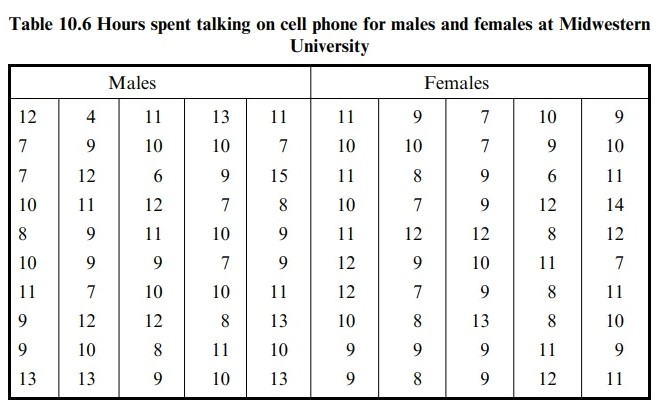

**Questions:**

1. Formulate and present the rationale for a hypothesis test that the researcher could use to compare the mean time spent on cell phones by male and female college students per week.
2. Analyze the data to provide the hypothesis testing conclusion. What is the p-value for your test? What is your recommendation for the researcher?
3. Provide descriptive statistical summaries of the data for each gender category.
4. What is the 95% confidence interval for the population mean of each gender category, and what is the 95% confidence interval for the difference between the means of the two populations?
5. Do you see a need for larger sample sizes and more testing with the time spent on cell phones? Discuss.
6. Make a report including the testing of the assumptions for two independent samples t-test.

## **Exploratory Data Analysis**

### **Environment Set-up and Data Import**

The following code is written in Python 3.x. Libraries provide pre-written functionality to perform necessary tasks.

In [ ]:
# load packages

import io
import sys # access to system parameters
import pandas as pd # collection of functions for data processing and analysis modeled after R dataframes with SQL like features
import numpy as np # foundational package for scientific computing

# hypothesis testing
from scipy.stats import shapiro
import scipy.stats as stats

import IPython
from IPython.display import HTML, display # pretty printing of dataframes in Jupyter notebook

# data visualization
import seaborn as sns
from matplotlib import pyplot as plt

# misc libraries
import random
import time

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

-------------------------


### **Acquire the Data**
The Python Pandas package facilitates working with datasets. Acquiring the training and testing datasets into Pandas DataFrames is the initial step, followed by combining these datasets to perform operations on both simultaneously.

In [ ]:
path = 'https://raw.githubusercontent.com/kofibeans/APM1111-SA/main/data.csv'

def load(path, info = True):
  if len(path.split(".csv")) > 1:
    read = pd.read_csv(path)
  elif len(path.split(".xlsx")) > 1:
    read = pd.read_excel(path)

  if info:
    if len(read) > 0:
      print("# Dimensions")
      print("Observation:", read.shape[0], "Column:", read.shape[1], "\n")
      print("# Dtypes")
      if len(read.select_dtypes("object").columns) > 0:
        print("-- Object Variables: ",
        len(read.select_dtypes("object").columns), " ",
        read.select_dtypes("object").columns.tolist(), "")

      if len(read.select_dtypes("integer").columns) > 0:
        print("-- Integer Variables: ",
        len(read.select_dtypes("integer").columns), " ",
        read.select_dtypes("integer").columns.tolist(), "")

      if len(read.select_dtypes("float").columns) > 0:
        print("-- Float Variables:",
        len(read.select_dtypes("float").columns), " ",
        read.select_dtypes("float").columns.tolist(), "")

      if len(read.select_dtypes("bool").columns) > 0:
         print("-- Bool Variables:",
        len(read.select_dtypes("bool").columns), " ",
        read.select_dtypes("bool").columns.tolist(), "")

      print("\n# Missing Value")
      print("-- Are there any missing values? ", np.where(read.isnull().values.any() == False, "[No missing value!]", "[Data includes missing value!]"), "\n")
      buf = io.StringIO()
      read.info(buf=buf)
      info = buf.getvalue().split('\n')[-2].split(":")[1].strip()
      print("# Memory Usage: ", info, "\n")

    else:
      print("# Data did not import!")

  return read

ab = load(path, info = True)

# Dimensions
Observation: 50 Column: 2 

# Dtypes
-- Integer Variables:  2   ['Male', 'Female'] 

# Missing Value
-- Are there any missing values?  [No missing value!] 

# Memory Usage:  928.0 bytes 



### **Summary Statistics**
Compute some summary statistics of the data set.

In [ ]:
# summary stats
ab.describe().round(2)

,Male,Female
count,50.00,50.00
mean,9.82,9.70
std,2.15,1.78
min,4.00,6.00
25%,9.00,9.00
50%,10.00,9.50
75%,11.00,11.00
max,15.00,14.00


In [ ]:
# calculate the difference between Male and Female data
difference = ab['Male'] - ab['Female']

# calculate the standard deviation of the difference
sd_difference = np.std(difference)

print("Standard Deviation of the Difference between Genders: ", sd_difference.round(3), "\n")

# calculate variances
var_male = np.var(ab['Male'], ddof = 1)
var_female = np.var(ab['Female'], ddof = 1)

# create a new DataFrame
variance_df = pd.DataFrame({
    'Category': ['Male', 'Female'],
    'Variance': [var_male, var_female]
})

# display the DataFrame
variance_df.style

Standard Deviation of the Difference between Genders:  2.747 



,Category,Variance
0,Male,4.640408
1,Female,3.153061


### **Assumption Check**
The assumptions based on the data analysis done so far need to be validated further before taking appropriate actions.

**Assumption 1:** You have one dependent variable that is measured at the continuous level.

> ***Remark.*** The dependent variable is called `hours` which denoted the number of hours per week spent talking on their cell phones, and it is at the continuous level.

**Assumption 2:** You have one independent variable that consists of two categorical, independent
groups.

> ***Remark.*** The independent variable is the `gender` which is categorized into independent groups: male and female.

**Assumption 3:** You should have independence of observations.

> ***Remark.*** Each observation is independent with each other as there is no relationship between the observations in each group of the independent variable or between the groups themselves.

**Assumption 4:** There should be no significant outliers in the groups of your independent variable in terms of the dependent variable.

**Outlier Detection through Boxplot**

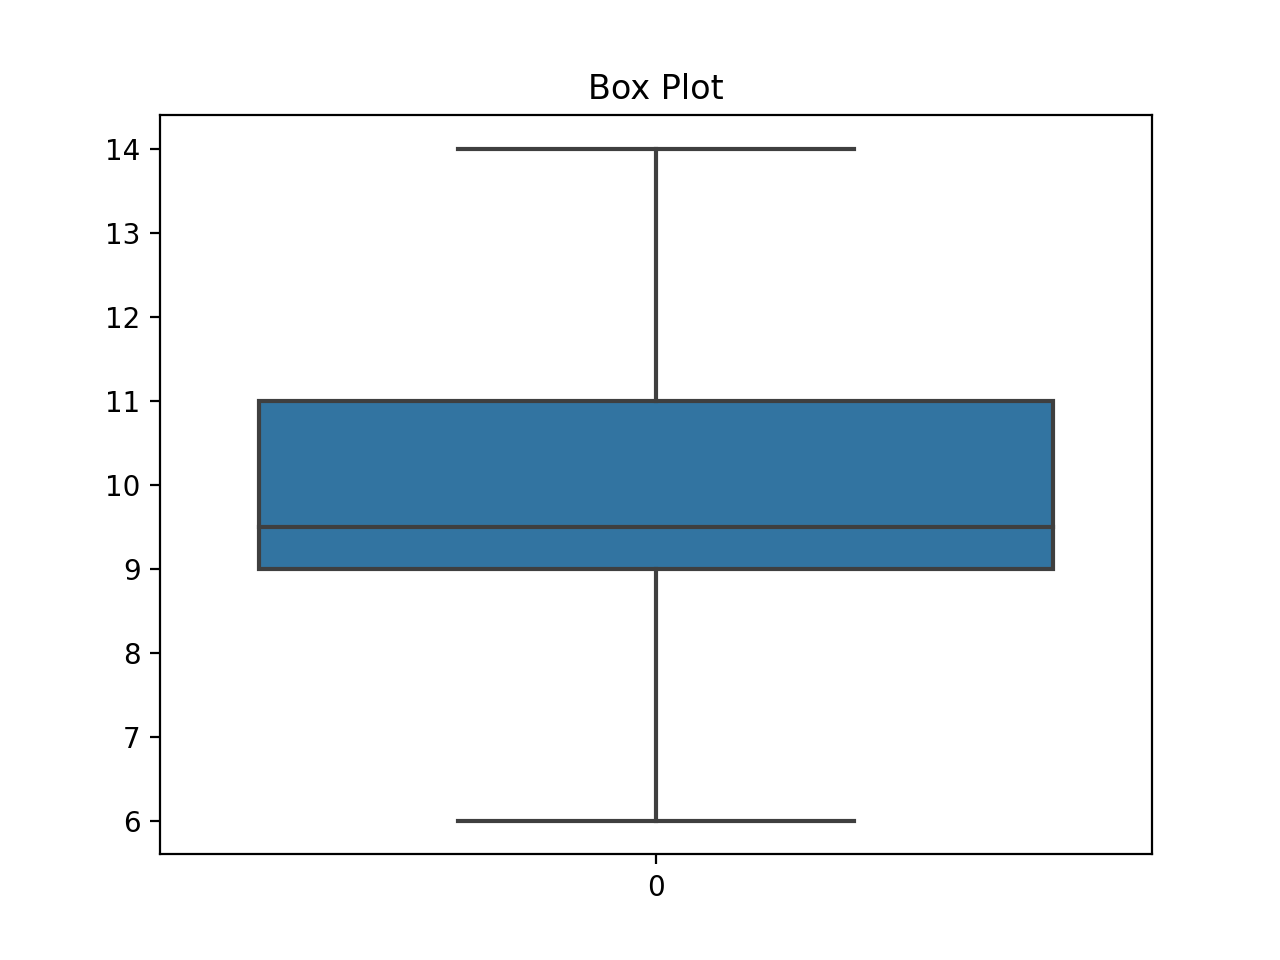

In [ ]:
def Box_plots(ab):
    plt.title("Box Plot")
    sns.boxplot(ab)
    plt.show()
Box_plots(ab['Female'])

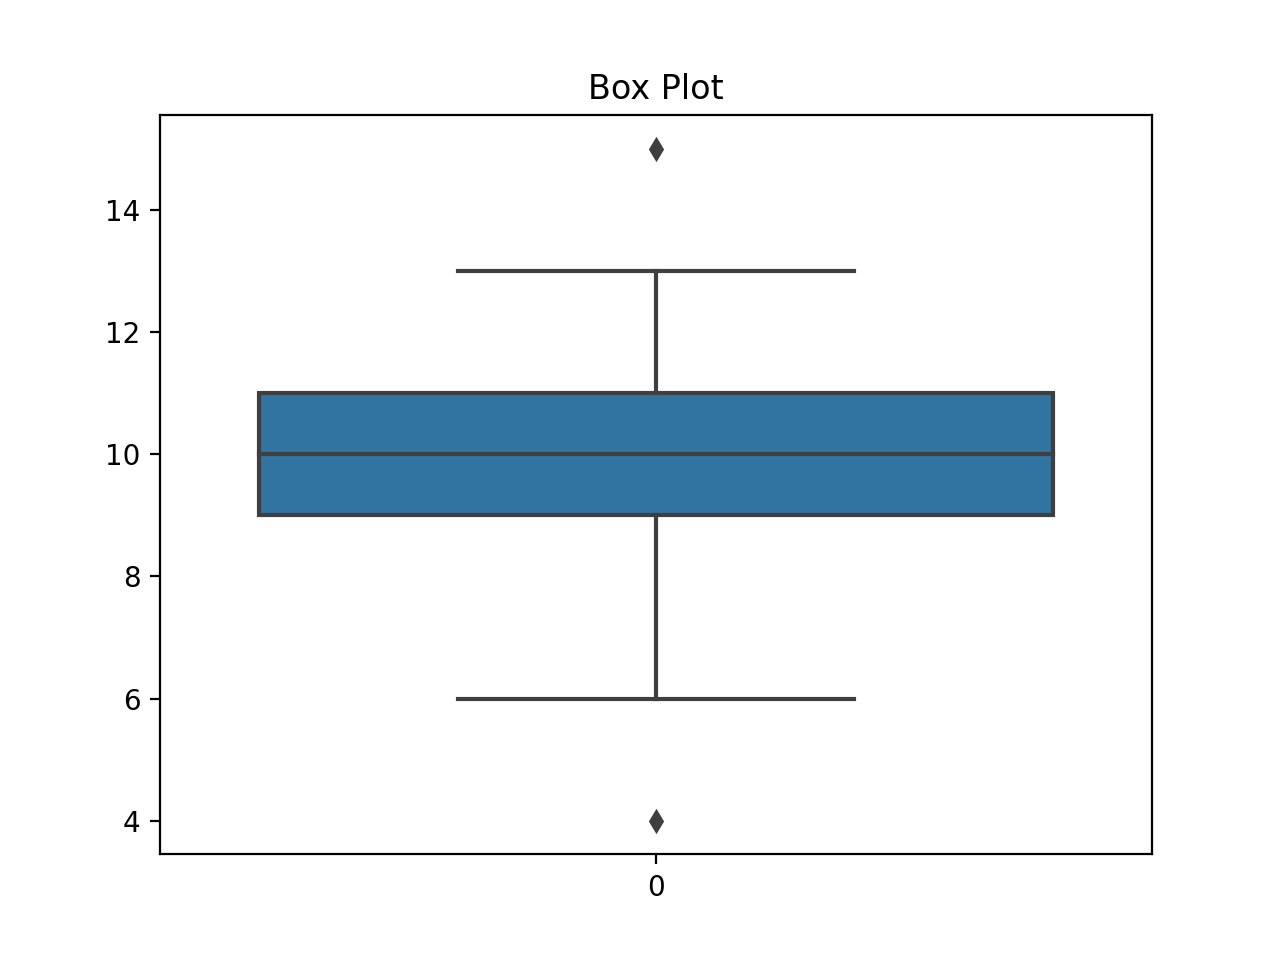

In [ ]:
def Box_plots(ab):
    plt.title("Box Plot")
    sns.boxplot(ab)
    plt.show()
Box_plots(ab['Male'])

> ***Remark.*** There are no significant outliers, as assessed by visual inspection of boxplots.

**Outlier Detection through z-score**

To identify outliers using the z-score, we can set a threshold value by 3. Data points with a z-score greater than 3 or less than -3 can be considered an outlier.

In [ ]:
# calculate z-scores for each group
ab['z_score'] = ab['Male'].transform(lambda x: (x - x.mean()) / x.std())

# identify outliers based on z-score threshold
outliers = ab[abs(ab['z_score']) > 3]

# display the outliers
print("The following data points are considered as outliers:")
print(outliers)

The following data points are considered as outliers:
Empty DataFrame
Columns: [Male, Female, z_score]
Index: []


> ***Remark.*** There were no outliers.

**Assumption 5:** Your dependent variable should be approximately normally distributed for each group of the independent variable.

In [ ]:
# checking the normality assumption for each group using Shapiro-Wilk test
group_0 = ab['Male']
group_1 = ab['Female']

shapiro_0 = stats.shapiro(group_0)
shapiro_1 = stats.shapiro(group_1)

# creating a table for the Shapiro-Wilk test results
results = pd.DataFrame({'Group': ['Male', 'Female'],
                        'W-statistic': [shapiro_0.statistic, shapiro_1.statistic],
                       'p-value': [shapiro_0.pvalue, shapiro_1.pvalue]})

print("\nTest of Normality (Shapiro-Wilk)")
results.style


Test of Normality (Shapiro-Wilk)


,Group,W-statistic,p-value
0,Male,0.974654,0.353992
1,Female,0.963877,0.129197


> ***Remark.*** The dependent variable (Hours) for each group (Gender) is normally distributed (p > 0.05), as assessed by Shapiro-Wilk test.

**Assumption 6:** You have homogeneity of variances (i.e., the variance of the dependent variable is equal in each group of your independent variable).

In [ ]:
# perform brown-forsythe test
bf_results = stats.levene(group_0, group_1, center = 'mean')

# create a dictionary with the results
results = {
    'F': bf_results.statistic,
    'df1': [2 - 1],
    'df2': [len(group_0) + len(group_1) - 2],
    'p': bf_results.pvalue
}

# create a dataframe with the results
results_f = pd.DataFrame(results)

# print and style the dataframe
print("\n Test of Equality of Variances (Levene's)")
results_f.style.format("{:,.2f}")


 Test of Equality of Variances (Levene's)


,F,df1,df2,p
0,0.90,1.00,98.00,0.35




> ***Remark.*** There is equality of variances between groups (male, female) on the number of hours per week spent talking on their cell phones (Hours), as assessed by Levene’s test of equality of variances.



### **Observations**

1.  Sample Size: 50
2.  Number of Samples: 2
3.  Degree of Freedom: 98
4.  There are no outliers in the given data.
5.  Both samples are normally distributed and there is an equality of variances between groups.

## **Hypothesis Formulation and Testing**

### **Formulation**

-   **Null Hypothesis (**$H_0$) There is no significant difference between the hours spent in their phones between genders (male and female).

-   **Alternative Hypothesis (**$H_a$) There is a significant difference between the hours spent in their phones between genders (male and female).

### **Testing**


**Population Means and Mean Difference**

In [135]:
# calculate the 95% confidence interval for each gender category
ci_male = stats.norm.interval(0.95, loc=np.mean(group_0), scale=np.std(group_0, ddof=1)/np.sqrt(len(group_0)))
ci_female = stats.norm.interval(0.95, loc=np.mean(group_1), scale=np.std(group_1, ddof=1)/np.sqrt(len(group_1)))

# calculate the 95% confidence interval for the difference between the means
diff_means = np.mean(group_0) - np.mean(group_1)
std_error_diff = np.sqrt((np.std(group_0, ddof=1)**2 / len(group_0)) + (np.std(group_1, ddof=1)**2 / len(group_1)))
ci_diff = stats.norm.interval(0.95, loc=diff_means, scale=std_error_diff)

# create a dataframe to display the results
data = {
    'Category': ['Male', 'Female'],
    'CI Lower': [ci_male[0], ci_female[0]],
    'CI Upper': [ci_male[1], ci_female[1]],
    'CI Diff':  [ci_diff[0], ci_diff[1]]
}

df = pd.DataFrame(data)
df.style

,Category,CI Lower,CI Upper,CI Diff
0,Male,9.222908,10.417092,-0.653800
1,Female,9.207814,10.192186,0.893800


**Two-tailed Independent Two Sample T-test**

In [137]:
from scipy.stats import ttest_ind

# perform independent samples t-test
t_statistic, p_value = ttest_ind(group_1, group_0)

# calculate mean difference
mean_difference = np.mean(group_1) - np.mean(group_0)

# calculate standard error of the difference
se_difference = np.sqrt(np.var(group_1, ddof = 1)/len(group_1) + np.var(group_0, ddof = 1)/len(group_0))

# calculate 95% CI for mean difference
ci_lower = mean_difference - 1.96 * se_difference
ci_upper = mean_difference + 1.96 * se_difference

# calculate effect size
cohen_d = mean_difference / se_difference

# create a dictionary with the results
results = {
    't': [t_statistic],
    'df': [len(group_0) + len(group_1) - 2],
    'p-value': [p_value],
    'eff size': -0.0607,
    'Mean Difference': [mean_difference],
    'SE Difference': [se_difference],
    '95% CI (Lower)': [ci_lower],
    '95% CI (Upper)': [ci_upper]
}

# create a dataframe from the dictionary
df_results = pd.DataFrame(results)

# format float of the dataframe
df_results.style.format("{:,.3f}")

,t,df,p-value,eff size,Mean Difference,SE Difference,95% CI (Lower),95% CI (Upper)
0,-0.304,98.000,0.762,-0.061,-0.120,0.395,-0.894,0.654


This table shows the output for the independent samples t-test. The differences between the groups are not statistically significant at the .05 level, which means that the data do not provide much motivation to reject the null hypothesis.

## **Conclusion**

#### **Independent Sample T Test**
-   The p-value is 0.762 which is greater than the 0.05.
-   The Cohen's d (effect size) is -0.0607.
-   95% confidence interval for difference in mean is [-0.903, 0.663].

#### **One Sample T Test**
-   Male: 95% confidence interval for difference in mean is [9.223,	10.417].
-   Female: 95% confidence interval for difference in mean is [9.208,	10.192].

#### **Sample Size**
The sample size N = 50.

#### **Reporting**

An independent samples t-test was conducted to compare the mean time spent on cell phones by male and female college students per week. Both samples are normally distributed and there is an equality of variances between groups.Hence, there is no significant difference for male (M = 9.82, SD = 2.15) and female (M = 9.70, SD = 1.78) students on the number of hours per week spent talking on their cell phones; t(98) = -0.304, p = 0.762.